## Benchmark Analysis notebook

In this notebook we gather the results from all the experiments and conduct statistical test to test the statistical significance of our results at the 10% significance level. 

## FashionMNIST


CrossEntropy summary:
    batch_size  mean_max     std     sem  n
0         128    0.9456  0.0016  0.0007  5
1         256    0.9434  0.0009  0.0004  5
2         512    0.9436  0.0007  0.0003  5
3        1024    0.9413  0.0010  0.0005  5
4        2048    0.9388  0.0008  0.0003  5
5        4096    0.9371  0.0010  0.0005  5
6        8192    0.9338  0.0019  0.0008  5

HyperSimplex summary:
    batch_size  mean_max     std     sem  n
0         128    0.9467  0.0007  0.0003  5
1         256    0.9473  0.0014  0.0006  5
2         512    0.9469  0.0014  0.0006  5
3        1024    0.9453  0.0007  0.0003  5
4        2048    0.9446  0.0014  0.0006  5
5        4096    0.9439  0.0008  0.0004  5
6        8192    0.9415  0.0011  0.0005  5

Hinge summary:
    batch_size  mean_max     std     sem  n
0         128    0.9452  0.0010  0.0005  5
1         256    0.9440  0.0011  0.0005  5
2         512    0.9437  0.0013  0.0006  5
3        1024    0.9423  0.0008  0.0004  5
4        2048    0.9407  0.0013 

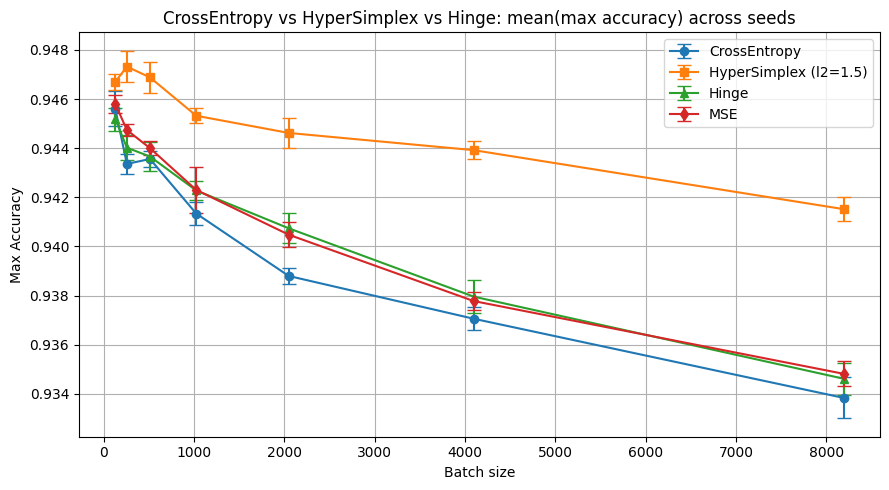

In [1]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

# -----------------------------
# Setup
# -----------------------------
ce_base = Path("Experiments/cross_entropy/FashionMNIST")
hs_base = Path("Experiments/hypersimplex/FashionMNIST")
hinge_base = Path("Experiments/hinge_loss/FashionMNIST")
mse_base = Path("Experiments/MSE_multiclass/FashionMNIST")

# adjust these if needed
ce_prefix = "cross_entropy"
hs_prefix = "Hyper_simplex_l2_1.5"
hinge_prefix = "hinge"   # e.g., "hinge", "MultiClassHinge", etc.
MSE_prefix = "MSE"   # e.g., "hinge", "MultiClassHinge", etc.

seeds = [0, 42, 1337, 2025, 31415]
batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]

def collect_results(base_path: Path, prefix: str) -> pd.DataFrame:
    results = []
    for bs in batch_sizes:
        max_accs = []
        for seed in seeds:
            path = base_path / f"seed_{seed}" / f"{prefix}_{bs}_acc_{seed}.npy"
            if path.exists():
                arr = np.load(path)
                max_accs.append(arr.max())
            else:
                print(f"[WARN] Missing {path}")

        if max_accs:
            max_accs = np.array(max_accs, dtype=float)
            mean = max_accs.mean()
            std = max_accs.std(ddof=1) if len(max_accs) > 1 else 0.0
            sem = std / np.sqrt(len(max_accs)) if len(max_accs) > 1 else 0.0
            results.append({
                "batch_size": bs,
                "mean_max": mean,
                "std": std,
                "sem": sem,
                "n": len(max_accs),
            })
    return pd.DataFrame(results)

# -----------------------------
# Collect CE, HS, and Hinge results
# -----------------------------
df_ce = collect_results(ce_base, ce_prefix)
df_hs = collect_results(hs_base, hs_prefix)
df_hg = collect_results(hinge_base, hinge_prefix)
df_mse = collect_results(mse_base, MSE_prefix)

print("\nCrossEntropy summary:\n", df_ce.round(4))
print("\nHyperSimplex summary:\n", df_hs.round(4))
print("\nHinge summary:\n", df_hg.round(4))
print("\nMSE summary:\n", df_mse.round(4))

# Optional: combined view (only rows where all three exist)
df_all = (df_ce.merge(df_hs, on="batch_size", suffixes=("_ce", "_hs"))
               .merge(df_hg, on="batch_size"))
df_all = df_all.rename(columns={
    "mean_max": "mean_max_hg",
    "std": "std_hg",
    "sem": "sem_hg",
    "n": "n_hg",
})
if not df_all.empty:
    print("\nCombined (shared batch_sizes only):\n", df_all.round(4))

# -----------------------------
# Plot comparison
# -----------------------------
plt.figure(figsize=(9, 5))

if not df_ce.empty:
    plt.errorbar(
        df_ce["batch_size"], df_ce["mean_max"], yerr=df_ce["sem"],
        fmt="o-", capsize=5, label="CrossEntropy"
    )
if not df_hs.empty:
    plt.errorbar(
        df_hs["batch_size"], df_hs["mean_max"], yerr=df_hs["sem"],
        fmt="s-", capsize=5, label="HyperSimplex (l2=1.5)"
    )
if not df_hg.empty:
    plt.errorbar(
        df_hg["batch_size"], df_hg["mean_max"], yerr=df_hg["sem"],
        fmt="^-", capsize=5, label="Hinge"
    )
if not df_mse.empty:
    plt.errorbar(
        df_mse["batch_size"], df_mse["mean_max"], yerr=df_mse["sem"],
        fmt="d-", capsize=5, label="MSE"
    )

plt.xlabel("Batch size")
plt.ylabel("Max Accuracy")
plt.title("CrossEntropy vs HyperSimplex vs Hinge: mean(max accuracy) across seeds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## FashionMNIST Statistical tests

In [4]:
import numpy as np
from pathlib import Path
from scipy.stats import ttest_rel

seeds = [0, 42, 1337, 2025, 31415]
batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]

ce_base = Path("Experiments/cross_entropy/FashionMNIST")
hs_base = Path("Experiments/hypersimplex/FashionMNIST")

def load_max_accs(base, prefix, bs, seeds):
    vals = []
    for seed in seeds:
        path = base / f"seed_{seed}" / f"{prefix}_{bs}_acc_{seed}.npy"
        if path.exists():
            arr = np.load(path)
            vals.append(arr.max())
    return np.array(vals)

results = []

for bs in batch_sizes:
    ce_vals = load_max_accs(ce_base, "cross_entropy", bs, seeds)
    hs_vals = load_max_accs(hs_base, "Hyper_simplex_l2_1.5", bs, seeds)

    if len(ce_vals) == len(hs_vals) and len(ce_vals) > 1:
        t_stat, p_val = ttest_rel(hs_vals, ce_vals)
        results.append({
            "batch_size": bs,
            "CE_mean": ce_vals.mean(),
            "HS_mean": hs_vals.mean(),
            "HS-CE_mean": (hs_vals - ce_vals).mean(),
            "t_stat": t_stat,
            "p_value": p_val,
            "n": len(ce_vals),
        })

# Pretty print
import pandas as pd
df = pd.DataFrame(results)
print(df.round(3))

   batch_size  CE_mean  HS_mean  HS-CE_mean  t_stat  p_value  n
0         128    0.946    0.947       0.001   1.306    0.261  5
1         256    0.943    0.947       0.004   4.337    0.012  5
2         512    0.944    0.947       0.003   5.507    0.005  5
3        1024    0.941    0.945       0.004   6.667    0.003  5
4        2048    0.939    0.945       0.006  12.969    0.000  5
5        4096    0.937    0.944       0.007   9.676    0.001  5
6        8192    0.934    0.942       0.008  14.993    0.000  5


## CIFAR10 Benchmarks


CrossEntropy summary:
    batch_size  mean_max     std     sem  n
0         128    0.8885  0.0018  0.0008  5
1         256    0.8843  0.0018  0.0008  5
2         512    0.8807  0.0012  0.0005  5
3        1024    0.8776  0.0011  0.0005  5
4        2048    0.8725  0.0017  0.0008  5
5        4096    0.8659  0.0019  0.0008  5
6        8192    0.8541  0.0024  0.0011  5

HyperSimplex summary:
    batch_size  mean_max     std     sem  n
0         128    0.8917  0.0015  0.0007  5
1         256    0.8874  0.0017  0.0008  5
2         512    0.8857  0.0016  0.0007  5
3        1024    0.8821  0.0009  0.0004  5
4        2048    0.8791  0.0018  0.0008  5
5        4096    0.8750  0.0011  0.0005  5
6        8192    0.8648  0.0034  0.0015  5

Hinge summary:
    batch_size  mean_max     std     sem  n
0         128    0.8831  0.0010  0.0004  5
1         256    0.8785  0.0025  0.0011  5
2         512    0.8741  0.0014  0.0006  5
3        1024    0.8694  0.0025  0.0011  5
4        2048    0.8666  0.0011 

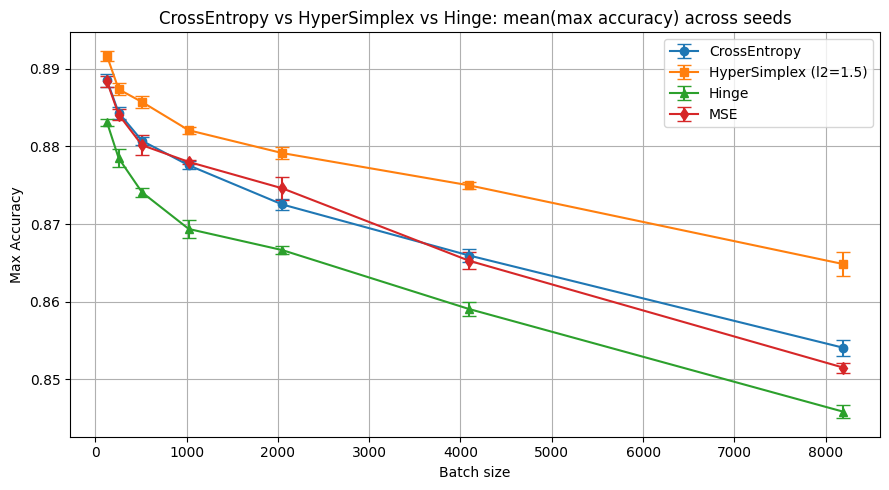

In [3]:
import numpy as np
import pandas as pd
from pathlib import Path
import os
import matplotlib.pyplot as plt

# -----------------------------
# Setup
# -----------------------------
ce_base = Path("Experiments/cross_entropy/CIFAR10")
hs_base = Path("Experiments/hypersimplex/CIFAR10")
hinge_base = Path("Experiments/hinge_loss/CIFAR10")
mse_base = Path("Experiments/MSE_multiclass/CIFAR10")

# adjust these if needed
ce_prefix = "cross_entropy"
hs_prefix = "Hyper_simplex_l2_1.5"
hinge_prefix = "hinge"
mse_prefix = "MSE"

seeds = [0, 42, 1337, 2025, 31415]
batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]

def collect_results(base_path: Path, prefix: str) -> pd.DataFrame:
    results = []
    for bs in batch_sizes:
        max_accs = []
        for seed in seeds:
            path = base_path / f"seed_{seed}" / f"{prefix}_{bs}_acc_{seed}.npy"
            if path.exists():
                arr = np.load(path)
                max_accs.append(arr.max())
            else:
                print(f"[WARN] Missing {path}")

        if max_accs:
            max_accs = np.array(max_accs, dtype=float)
            mean = max_accs.mean()
            std = max_accs.std(ddof=1) if len(max_accs) > 1 else 0.0
            sem = std / np.sqrt(len(max_accs)) if len(max_accs) > 1 else 0.0
            results.append({
                "batch_size": bs,
                "mean_max": mean,
                "std": std,
                "sem": sem,
                "n": len(max_accs),
            })
    return pd.DataFrame(results)

# -----------------------------
# Collect CE, HS, and Hinge results
# -----------------------------
df_ce = collect_results(ce_base, ce_prefix)
df_hs = collect_results(hs_base, hs_prefix)
df_hg = collect_results(hinge_base, hinge_prefix)
df_mse = collect_results(mse_base, mse_prefix)

print("\nCrossEntropy summary:\n", df_ce.round(4))
print("\nHyperSimplex summary:\n", df_hs.round(4))
print("\nHinge summary:\n", df_hg.round(4))
print("\nMSE summary:\n", df_mse.round(4))

# Optional: combined view (only rows where all three exist)
df_all = (df_ce.merge(df_hs, on="batch_size", suffixes=("_ce", "_hs"))
               .merge(df_hg, on="batch_size"))
df_all = df_all.rename(columns={
    "mean_max": "mean_max_hg",
    "std": "std_hg",
    "sem": "sem_hg",
    "n": "n_hg",
})
if not df_all.empty:
    print("\nCombined (shared batch_sizes only):\n", df_all.round(4))

# -----------------------------
# Plot comparison
# -----------------------------
plt.figure(figsize=(9, 5))

if not df_ce.empty:
    plt.errorbar(
        df_ce["batch_size"], df_ce["mean_max"], yerr=df_ce["sem"],
        fmt="o-", capsize=5, label="CrossEntropy"
    )
if not df_hs.empty:
    plt.errorbar(
        df_hs["batch_size"], df_hs["mean_max"], yerr=df_hs["sem"],
        fmt="s-", capsize=5, label="HyperSimplex (l2=1.5)"
    )
if not df_hg.empty:
    plt.errorbar(
        df_hg["batch_size"], df_hg["mean_max"], yerr=df_hg["sem"],
        fmt="^-", capsize=5, label="Hinge"
    )
if not df_mse.empty:
    plt.errorbar(
        df_mse["batch_size"], df_mse["mean_max"], yerr=df_mse["sem"],
        fmt="d-", capsize=5, label="MSE"
    )

plt.xlabel("Batch size")
plt.ylabel("Max Accuracy")
plt.title("CrossEntropy vs HyperSimplex vs Hinge: mean(max accuracy) across seeds")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## CIFAR10 Statistical tests

In [2]:
import numpy as np
from pathlib import Path
from scipy.stats import ttest_rel

seeds = [0, 42, 1337, 2025, 31415]
batch_sizes = [128, 256, 512, 1024, 2048, 4096, 8192]

ce_base = Path("Experiments/cross_entropy/CIFAR10")
hs_base = Path("Experiments/hypersimplex/CIFAR10")

def load_max_accs(base, prefix, bs, seeds):
    vals = []
    for seed in seeds:
        path = base / f"seed_{seed}" / f"{prefix}_{bs}_acc_{seed}.npy"
        if path.exists():
            arr = np.load(path)
            vals.append(arr.max())
    return np.array(vals)

results = []

for bs in batch_sizes:
    ce_vals = load_max_accs(ce_base, "cross_entropy", bs, seeds)
    hs_vals = load_max_accs(hs_base, "Hyper_simplex_l2_1.5", bs, seeds)

    if len(ce_vals) == len(hs_vals) and len(ce_vals) > 1:
        t_stat, p_val = ttest_rel(hs_vals, ce_vals)
        results.append({
            "batch_size": bs,
            "CE_mean": ce_vals.mean(),
            "HS_mean": hs_vals.mean(),
            "HS-CE_mean": (hs_vals - ce_vals).mean(),
            "t_stat": t_stat,
            "p_value": p_val,
            "n": len(ce_vals),
        })

# Pretty print
import pandas as pd
df = pd.DataFrame(results)
print(df.round(4))

   batch_size  CE_mean  HS_mean  HS-CE_mean   t_stat  p_value  n
0         128   0.8885   0.8917      0.0032   2.2867   0.0842  5
1         256   0.8843   0.8874      0.0030   3.4747   0.0255  5
2         512   0.8807   0.8857      0.0050   6.0768   0.0037  5
3        1024   0.8776   0.8821      0.0045   9.7846   0.0006  5
4        2048   0.8725   0.8791      0.0066   7.8050   0.0015  5
5        4096   0.8659   0.8750      0.0090  13.1360   0.0002  5
6        8192   0.8541   0.8648      0.0108   8.5239   0.0010  5
